### Creating a ReAct, Multimodal and Agentic Multimodal RAG

In [19]:
"""
ReAct (Reasoning + Acting) is a framework where an LLM:
Reasons step by step (eg: decomposes questions, makes decisions)
Acts by calling tools like search, retrievers or other tools
"""
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent
from langchain.agents import Tool
from typing import Annotated, TypedDict, Sequence, List, Dict
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [8]:
# loading environment variables
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = ChatOpenAI(model="gpt-5-nano")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x00000292EE5E7FB0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000292EE5CB0E0>, root_client=<openai.OpenAI object at 0x00000292EE5B3950>, root_async_client=<openai.AsyncOpenAI object at 0x00000292EE5D8E90>, model_name='gpt-5-nano', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [24]:
# loading data and creating retriever

def create_retriever(chunk_size: int, chunk_overlap: int):
    # loading the data
    docs = PyPDFLoader("data/AI2Agent.pdf").load()

    # splitting data into chunks
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(docs)

    # initiate vectorstore
    embedding = OpenAIEmbeddings(model="text-embedding-3-small")
    vectorstore = FAISS.from_documents(chunks, embedding)
    print(type(vectorstore))
    retriever = vectorstore.as_retriever()

    return retriever

retriever = create_retriever(chunk_size=500, chunk_overlap=50)

<class 'langchain_community.vectorstores.faiss.FAISS'>


In [4]:
retriever

VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x00000292EE5B3410>, search_kwargs={})

In [5]:
# create the tools
def retriever_tool_fn(query: str):
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

retriever_tool = Tool(
    name="retriever",
    description="Use this tool to fetch relevant knowledge base info",
    func=retriever_tool_fn
)
retriever_tool

Tool(name='retriever', description='Use this tool to fetch relevant knowledge base info', func=<function retriever_tool_fn at 0x00000292F06DF420>)

C:\Users\gsben\AppData\Local\Temp\ipykernel_41816\3838766103.py:4: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node = create_react_agent(llm, tools)


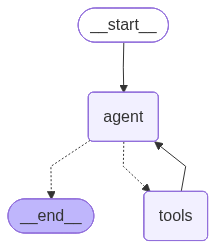

In [9]:
tools = [retriever_tool]

# create the ReAct agent
react_node = create_react_agent(llm, tools)
react_node

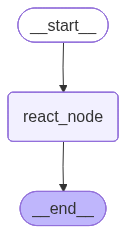

In [11]:
# Build the graph
class state(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Build the graph
builder = StateGraph(state_schema=state)
builder.add_node("react_node", react_node)
builder.set_entry_point("react_node")
builder.add_edge("react_node", END)

graph = builder.compile()
graph

In [13]:
# Run the ReAct agent

user_query = "What is the AI2Agent framework about?"
state = {"messages": HumanMessage(content=user_query)}
result = graph.invoke(state)
print(f"\nFinal answer: \n {result["messages"][-1].content}")


Final answer: 
 AI2Agent is an end-to-end framework for deploying AI projects as autonomous agents. Its goal is to make AI deployments more automated, reusable, and adaptable by turning a project into a self-contained agent that can execute tasks guided by predefined guidelines.

Key ideas:
- Automatic transformation: Takes an AI project and converts it into an autonomous agent that can reason, act, and adapt.
- Intelligent reasoning and debugging: Integrates reasoning, automated debugging, and iterative experience accumulation to improve deployment success over time.
- Guided, automated workflow: When you submit a request (for example, “generate a talk show in a specific style”), AI2Agent searches for a suitable project, follows a predefined execution guide, auto-deploys, and auto-diagnoses issues to ensure success.
- Beyond traditional DevOps: Unlike static templates used by DevOps/AutoDevOps, AI2Agent emphasizes autonomous decision-making, dynamic deployment, and iterative refineme

In [14]:
user_query = "What are the limitations and potential improvements to add or explore about the AI2Agent framework?"
state = {"messages": HumanMessage(content=user_query)}
result = graph.invoke(state)
print(f"\nFinal answer: \n {result["messages"][-1].content}")


Final answer: 
 Here’s a concise view grounded in the AI2Agent description you shared: it’s an end-to-end framework that automates deploying AI projects as autonomous agents, with features like intelligent reasoning, automated debugging, and iterative experience accumulation. The text also notes that there are limitations and a call for community contributions to improve it.

Limitations (areas that typically need attention in such frameworks)
- Deployment complexity as projects scale
  - As AI projects grow more complex, ensuring seamless, reliable deployments can become harder and may require more sophisticated orchestration and monitoring.
- Dependence on underlying AI models and components
  - The quality of automation depends on the accuracy and stability of the embedded models and tools; model drift and updates can affect reliability.
- Transparency and debugability
  - Automated reasoning and debugging can be opaque; there’s a risk that decisions or fixes are hard to interpret 

### Building a Multimodal RAG that handles (text + images)

In [20]:
import fitz
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from langchain.schema import Document
import io
import base64
from dataclasses import dataclass

In [18]:
# Load CLIP model and CLIP Processor
# Initialize the CLIP model for unified embeddings

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [33]:
# # Multimodal EMbedding class
# @dataclass
# class MUltiModalEmbeddings:
#     """Class for creating multimodal embeddings"""
#     def embed_image(self, image_data):
#         if isinstance(image_data, str):
#             image = Image.open(image_data).convert("RGB")
#         else: # if PIL image
#             image = image_data
        
#         inputs = processor(imaes=image, return_tensors="pt")
#         with torch.no_grad():
#             features = clip_model.get_image_features(**inputs)
#             # Normalize the features
#             features = self.normalize_features(features)

#     def embed_text(self, text):
#         """Embed text using CLIP"""
#         inputs = processor(
#             text=text,
#             return_tensors="pt",
#             padding=True,
#             truncation=True,
#             max_length=77 # CLIP's max token
#         )
#         with torch.no_grad():
#             features = clip_model.get_text_features(**inputs)
#             features = self.normalize_features(features)


#     def normalize_features(self, features):
#         features = features / features.norm(dim=-1, keepdim=True)
#         return features.squeeze().numpy

# class DataEmbedding:
#     def __init__(self):
#         self.all_docs = []
#         self.all_embeddings = []
#         self.image_data_store = []

#     def loading_data_and_embedding(pdf_path):
#         # pdf_path = "data/AI2Agent.pdf"
#         doc = fitz.open(pdf_path)

#         # Text Splitter
#         text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

#         for i, page in enumerate(doc):
#             # Process text
#             text = page.get_text()
#             if text.strip():
#                 temp_doc = Document(page_content=text, metadata={"page":i, "type":"text"})
#                 text_chunks = text_splitter.split_documents([temp_doc])

#                 # Embed each chunk using CLIP
#                 for chunk in text_chunks:
#                     embedding = MUltiModalEmbeddings.embed_text(chunk)
#                     self.all_embeddings.append(embedding)
#                     self.all_docs.append(chunk)
#             # process image
#             """
#             Convert PDF image to PIL image
#             Store as Base64 for GPT-4V model
#             create CLIP embedding for retrieval
#             """
#             for img_index, img in enumerate(page.get_images(full=True)):
#                 try:
#                     xref = img[0]
#                     base_image = doc.extract_image(xref)
#                     image_bytes = base_image["image"]

#                     # Convert to PIL Image
#                     pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

#                     # create unique identifier
#                     image_id = f"page_{i}_img_{img_index}"

#                     # store image as base64 for later use with GPT-4V
#                     buffered = io.BytesIO()
#                     pil_image.save(buffered, format="PNG")
#                     img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
#                     self.image_data_store[image_id] = img_base64

#                     # Embed document using CLIP
#                     embedding = MUltiModalEmbeddings.embed_image(pil_image)
#                     self.all_embeddings.append(embedding)

#                     # create document for image
#                     img_doc = Document(page_content=f"[Image: {image_id}]", metadata={"page": i, "type": "image", "image_id": image_id})
#                     self.all_docs.append(img_doc)
#                 except Exception as e:
#                     print(f"Error processing image on page {i}, image {img_index}: {e}")
#                     continue
#         doc.close()
#         return self.all_docs, self.all_embeddings, self.image_data_store
    

# @dataclass
# class VectorStore:
#     all_docs: List
#     all_embeddings: List
#     image_data_store: Dict

#     # create unified FAISS vector store with CLIP embeddings
#     def create_vectorstore(self):
#         embedding_array = np.array(self.all_embeddings)
#         # create custom FAISS
#         vector_store = FAISS.from_embeddings(
#             text_embeddings=[(doc.page_content, emb) for doc, emb in zip(self.all_docs, embedding_array)],
#             embedding=None,
#             metadatas=[doc.metadata for doc in self.all_docs]
#         )
#         return vector_store
    
# @dataclass
# class MultiModalRetrieval:
#     query: str
#     vectorStore: FAISS
#     k: int=5

#     def retrieve_multimodal(self):
#         """Unified retrieval for text and images"""
#         # Embed query using CLIP
#         query_embedding = MUltiModalEmbeddings.embed_text(self.query)
#         # search in unified vector
#         results = self.vectorStore.similarity_search_by_vector(
#             embedding=query_embedding,
#             k=self.k
#         )
#         return results
    
#     def create_multimodal_message(self, retrieved_docs, image_data_store):
#         """Create a message with both text and images for GPT-4V"""
#         content = []

#         # Add the query
#         content.append({
#             "type": "text",
#             "text": f"Question: {self.query}\n\nContext:\n"
#         })

#         # Separate text and image documents
#         text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
#         image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]

#         # Add text context
#         if text_docs:
#             text_context = "\n\n".join([
#                 f"[Page {doc.metadata['page']}]: {doc.page_content}"
#                 for doc in text_docs
#             ])
#             content.append({
#                 "type": "text",
#                 "text": f"Text exerpts:\n{text_context}\n"
#             })

#         # Add images context
#         for doc in image_docs:
#             image_id = doc.metadata.get("image_id")
#             if image_id and image_id in image_data_store:
#                 content.append({
#                     "type": "text",
#                     "text": f"\n[Image from page {doc.metadata['page']}]\n"
#                 })
#                 content.append({
#                     "type": "image_url",
#                     "image_url": {
#                         "url": f"data:image/png;base64,{image_data_store[image_id]}",
#                         "alt_text": f"Image from page {doc.metadata['page']}"
#                     }
#                 })

#         # Add instruction
#         content.append({
#             "type": "text",
#             "text": "\nAnswer the question based on the provided context. If the context does not contain the answer, say 'I don't know'."
#         })

#         return HumanMessage(content=content)
    
# @dataclass
# class MultiModalRAG:
#     query: str
#     k: int
#     llm: ChatOpenAI

#     def generate(self):
#         """Main Pipeline for multimodal RAG"""
#         # retrieve relevant documents
#         context_docs = MultiModalRetrieval.retrieve_multimodal(self.query, self.k)

#         # create multimodal message
#         message = MultiModalRetrieval.create_multimodal_message(self.query, context_docs)

#         # Get response from LLM
#         response = llm.invoke([message])
#         print(f"\n Final Answer:\n {response.content}")

In [58]:
import fitz
import io
import base64
import numpy as np
import torch
from PIL import Image
from dataclasses import dataclass
from typing import List, Dict
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.schema.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Assume these are initialized somewhere
# from transformers import CLIPProcessor, CLIPModel
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


# Multimodal Embedding class
@dataclass
class MultiModalEmbeddings:  # Fixed: MUltiModalEmbeddings -> MultiModalEmbeddings
    """Class for creating multimodal embeddings"""
    
    def embed_image(self, image_data):
        if isinstance(image_data, str):
            image = Image.open(image_data).convert("RGB")
        else:  # if PIL image
            image = image_data
        
        inputs = processor(images=image, return_tensors="pt")  # Fixed: imaes -> images
        with torch.no_grad():
            features = clip_model.get_image_features(**inputs)
            # Normalize the features
            features = self.normalize_features(features)
            return features  # Fixed: Added return statement

    def embed_text(self, text):
        """Embed text using CLIP"""
        inputs = processor(
            text=text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77  # CLIP's max token
        )
        with torch.no_grad():
            features = clip_model.get_text_features(**inputs)
            features = self.normalize_features(features)
            return features  # Fixed: Added return statement

    def normalize_features(self, features):
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()  # Fixed: .numpy -> .numpy()


class DataEmbedding:
    def __init__(self):
        self.all_docs = []
        self.all_embeddings = []
        self.image_data_store = {}  # Fixed: [] -> {} (should be dict)
        self.embedder = MultiModalEmbeddings()  # Fixed: Create instance

    def loading_data_and_embedding(self, pdf_path):  # Fixed: Added self parameter
        # pdf_path = "data/AI2Agent.pdf"
        doc = fitz.open(pdf_path)

        # Text Splitter
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

        for i, page in enumerate(doc):
            # Process text
            text = page.get_text()
            if text.strip():
                temp_doc = Document(page_content=text, metadata={"page": i, "type": "text"})
                text_chunks = text_splitter.split_documents([temp_doc])

                # Embed each chunk using CLIP
                for chunk in text_chunks:
                    embedding = self.embedder.embed_text(chunk.page_content)  # Fixed: Use instance and pass text content
                    self.all_embeddings.append(embedding)
                    self.all_docs.append(chunk)
            
            # process image
            """
            Convert PDF image to PIL image
            Store as Base64 for GPT-4V model
            create CLIP embedding for retrieval
            """
            for img_index, img in enumerate(page.get_images(full=True)):
                try:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_bytes = base_image["image"]

                    # Convert to PIL Image
                    pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

                    # create unique identifier
                    image_id = f"page_{i}_img_{img_index}"

                    # store image as base64 for later use with GPT-4V
                    buffered = io.BytesIO()
                    pil_image.save(buffered, format="PNG")
                    img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
                    self.image_data_store[image_id] = img_base64

                    # Embed document using CLIP
                    embedding = self.embedder.embed_image(pil_image)  # Fixed: Use instance
                    self.all_embeddings.append(embedding)

                    # create document for image
                    img_doc = Document(
                        page_content=f"[Image: {image_id}]",
                        metadata={"page": i, "type": "image", "image_id": image_id}
                    )
                    self.all_docs.append(img_doc)
                except Exception as e:
                    print(f"Error processing image on page {i}, image {img_index}: {e}")
                    continue
        
        doc.close()
        return self.all_docs, self.all_embeddings, self.image_data_store


@dataclass
class VectorStore:
    all_docs: List
    all_embeddings: List
    image_data_store: Dict

    # create unified FAISS vector store with CLIP embeddings
    def create_vectorstore(self):
        embedding_array = np.array(self.all_embeddings)
        # create custom FAISS
        vector_store = FAISS.from_embeddings(
            text_embeddings=[(doc.page_content, emb) for doc, emb in zip(self.all_docs, embedding_array)],
            embedding=None,
            metadatas=[doc.metadata for doc in self.all_docs]
        )
        return vector_store


@dataclass
class MultiModalRetrieval:
    query: str
    vectorStore: FAISS
    image_data_store: Dict  # Fixed: Added missing parameter
    k: int = 5  # Fixed: Moved to end (default args must come after non-default)

    def __post_init__(self):  # Fixed: Create embedder instance
        self.embedder = MultiModalEmbeddings()

    def retrieve_multimodal(self):
        """Unified retrieval for text and images"""
        # Embed query using CLIP
        query_embedding = self.embedder.embed_text(self.query)  # Fixed: Use instance
        # search in unified vector
        results = self.vectorStore.similarity_search_by_vector(
            embedding=query_embedding,
            k=self.k
        )
        return results

    def create_multimodal_message(self, retrieved_docs):  # Fixed: Removed image_data_store param (use self)
        """Create a message with both text and images for GPT-4V"""
        content = []

        # Add the query
        content.append({
            "type": "text",
            "text": f"Question: {self.query}\n\nContext:\n"
        })

        # Separate text and image documents
        text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
        image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]

        # Add text context
        if text_docs:
            text_context = "\n\n".join([
                f"[Page {doc.metadata['page']}]: {doc.page_content}"
                for doc in text_docs
            ])
            content.append({
                "type": "text",
                "text": f"Text excerpts:\n{text_context}\n"  # Fixed: exerpts -> excerpts
            })

        # Add images context
        for doc in image_docs:
            image_id = doc.metadata.get("image_id")
            if image_id and image_id in self.image_data_store:  # Fixed: Use self.image_data_store
                content.append({
                    "type": "text",
                    "text": f"\n[Image from page {doc.metadata['page']}]\n"
                })
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{self.image_data_store[image_id]}",  # Fixed: Use self
                        "alt_text": f"Image from page {doc.metadata['page']}"
                    }
                })

        # Add instruction
        content.append({
            "type": "text",
            "text": "\nAnswer the question based on the provided context. If the context does not contain the answer, say 'I don't know'."
        })

        return HumanMessage(content=content)


@dataclass
class MultiModalRAG:
    query: str
    vectorStore: FAISS  # Fixed: Added missing parameter
    image_data_store: Dict  # Fixed: Added missing parameter
    llm: ChatOpenAI
    k: int = 5  # Fixed: Moved to end

    def generate(self):
        """Main Pipeline for multimodal RAG"""
        # retrieve relevant documents
        retriever = MultiModalRetrieval(  # Fixed: Create instance with all required params
            query=self.query,
            vectorStore=self.vectorStore,
            image_data_store=self.image_data_store,
            k=self.k
        )
        context_docs = retriever.retrieve_multimodal()  # Fixed: Call on instance

        # create multimodal message
        message = retriever.create_multimodal_message(context_docs)  # Fixed: Call on instance with correct params

        # Get response from LLM
        response = self.llm.invoke([message])  # Fixed: Use self.llm
        print(f"\nFinal Answer:\n{response.content}")  # Fixed: Spacing in f-string

In [61]:
# Data Ingestion
path = "data/AI2Agent.pdf"
llm_model = ChatOpenAI(model="gpt-4.1-mini")
query = "What are the main findings of this paper?"
# Initialize data embedding
data_embedder = DataEmbedding()
all_docs, all_embeddings, image_data_store = data_embedder.loading_data_and_embedding(path)
    
# Create vector store
vs = VectorStore(all_docs, all_embeddings, image_data_store)
vector_store = vs.create_vectorstore()
    
# Run RAG
rag = MultiModalRAG(
    query=query,
    vectorStore=vector_store,
    image_data_store=image_data_store,
    llm=llm_model,
    k=5
)
rag.generate()

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.



Final Answer:
The main findings of the paper are:

1. Introduction of AI2Agent, a system designed to enhance the deployment of AI applications by promoting efficiency while ensuring responsible AI practices.
2. The system employs a self-adaptive debugging process during execution steps to iteratively search for and execute solutions until successful.
3. AI2Agent accumulates cases and solutions over time to improve performance.
4. It strictly utilizes publicly available APIs without involving the training or fine-tuning of large language models (LLMs).
5. The work includes a demonstration case using Spark-TTS, an efficient LLM-based text-to-speech model.

Overall, the paper presents a framework for auto-deploying AI agents that facilitates streamlined, efficient, and responsible AI application deployment.


###  Multimodal Agentic RAG

In [ ]:
import fitz
import io
import base64
import numpy as np
import torch
from PIL import Image
from dataclasses import dataclass
from typing import List, Dict, Optional, Any
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.schema.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain.agents import Tool, AgentExecutor, create_react_agent
from langchain.prompts import PromptTemplate
from langchain_community.tools import DuckDuckGoSearchRun

# Assume these are initialized somewhere
# from transformers import CLIPProcessor, CLIPModel
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
# clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


# ============= MULTIMODAL RAG COMPONENTS (from previous code) =============

@dataclass
class MultiModalEmbeddings:
    """Class for creating multimodal embeddings"""
    
    def embed_image(self, image_data):
        if isinstance(image_data, str):
            image = Image.open(image_data).convert("RGB")
        else:
            image = image_data
        
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            features = clip_model.get_image_features(**inputs)
            features = self.normalize_features(features)
            return features

    def embed_text(self, text):
        """Embed text using CLIP"""
        inputs = processor(
            text=text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        )
        with torch.no_grad():
            features = clip_model.get_text_features(**inputs)
            features = self.normalize_features(features)
            return features

    def normalize_features(self, features):
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()


class DataEmbedding:
    def __init__(self):
        self.all_docs = []
        self.all_embeddings = []
        self.image_data_store = {}
        self.embedder = MultiModalEmbeddings()

    def loading_data_and_embedding(self, pdf_path):
        doc = fitz.open(pdf_path)
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

        for i, page in enumerate(doc):
            # Process text
            text = page.get_text()
            if text.strip():
                temp_doc = Document(page_content=text, metadata={"page": i, "type": "text"})
                text_chunks = text_splitter.split_documents([temp_doc])

                for chunk in text_chunks:
                    embedding = self.embedder.embed_text(chunk.page_content)
                    self.all_embeddings.append(embedding)
                    self.all_docs.append(chunk)
            
            # Process images
            for img_index, img in enumerate(page.get_images(full=True)):
                try:
                    xref = img[0]
                    base_image = doc.extract_image(xref)
                    image_bytes = base_image["image"]

                    pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
                    image_id = f"page_{i}_img_{img_index}"

                    buffered = io.BytesIO()
                    pil_image.save(buffered, format="PNG")
                    img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
                    self.image_data_store[image_id] = img_base64

                    embedding = self.embedder.embed_image(pil_image)
                    self.all_embeddings.append(embedding)

                    img_doc = Document(
                        page_content=f"[Image: {image_id}]",
                        metadata={"page": i, "type": "image", "image_id": image_id}
                    )
                    self.all_docs.append(img_doc)
                except Exception as e:
                    print(f"Error processing image on page {i}, image {img_index}: {e}")
                    continue
        
        doc.close()
        return self.all_docs, self.all_embeddings, self.image_data_store


@dataclass
class VectorStore:
    all_docs: List
    all_embeddings: List
    image_data_store: Dict

    def create_vectorstore(self):
        embedding_array = np.array(self.all_embeddings)
        vector_store = FAISS.from_embeddings(
            text_embeddings=[(doc.page_content, emb) for doc, emb in zip(self.all_docs, embedding_array)],
            embedding=None,
            metadatas=[doc.metadata for doc in self.all_docs]
        )
        return vector_store


@dataclass
class MultiModalRetrieval:
    query: str
    vectorStore: FAISS
    image_data_store: Dict
    k: int = 5

    def __post_init__(self):
        self.embedder = MultiModalEmbeddings()

    def retrieve_multimodal(self):
        """Unified retrieval for text and images"""
        query_embedding = self.embedder.embed_text(self.query)
        results = self.vectorStore.similarity_search_by_vector(
            embedding=query_embedding,
            k=self.k
        )
        return results

    def create_multimodal_message(self, retrieved_docs):
        """Create a message with both text and images for GPT-4V"""
        content = []

        content.append({
            "type": "text",
            "text": f"Question: {self.query}\n\nContext:\n"
        })

        text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
        image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]

        if text_docs:
            text_context = "\n\n".join([
                f"[Page {doc.metadata['page']}]: {doc.page_content}"
                for doc in text_docs
            ])
            content.append({
                "type": "text",
                "text": f"Text excerpts:\n{text_context}\n"
            })

        for doc in image_docs:
            image_id = doc.metadata.get("image_id")
            if image_id and image_id in self.image_data_store:
                content.append({
                    "type": "text",
                    "text": f"\n[Image from page {doc.metadata['page']}]\n"
                })
                content.append({
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{self.image_data_store[image_id]}",
                        "alt_text": f"Image from page {doc.metadata['page']}"
                    }
                })

        content.append({
            "type": "text",
            "text": "\nAnswer the question based on the provided context. If the context does not contain the answer, say 'I don't know'."
        })

        return HumanMessage(content=content)


@dataclass
class MultiModalRAG:
    query: str
    vectorStore: FAISS
    image_data_store: Dict
    llm: ChatOpenAI
    k: int = 5

    def generate(self):
        """Main Pipeline for multimodal RAG"""
        retriever = MultiModalRetrieval(
            query=self.query,
            vectorStore=self.vectorStore,
            image_data_store=self.image_data_store,
            k=self.k
        )
        context_docs = retriever.retrieve_multimodal()

        message = retriever.create_multimodal_message(context_docs)

        response = self.llm.invoke([message])
        
        # Return both response and metadata for the agent
        return {
            "answer": response.content,
            "sources": [{"page": doc.metadata["page"], "type": doc.metadata["type"]} 
                       for doc in context_docs],
            "num_images": len([doc for doc in context_docs if doc.metadata.get("type") == "image"]),
            "num_text_chunks": len([doc for doc in context_docs if doc.metadata.get("type") == "text"])
        }


# ============= AGENTIC RAG WRAPPER =============

class MultiModalRAGSystem:
    """
    Singleton class to manage the multimodal RAG system state.
    This ensures we don't rebuild embeddings on every query.
    """
    _instance = None
    _initialized = False
    
    def __new__(cls):
        if cls._instance is None:
            cls._instance = super(MultiModalRAGSystem, cls).__new__(cls)
        return cls._instance
    
    def initialize(self, pdf_path: str, vision_llm: ChatOpenAI):
        """Initialize the RAG system with a PDF document"""
        if self._initialized:
            print("RAG system already initialized. Skipping...")
            return
        
        print(f"Initializing multimodal RAG system with {pdf_path}...")
        
        # Load and embed data
        data_embedder = DataEmbedding()
        self.all_docs, self.all_embeddings, self.image_data_store = \
            data_embedder.loading_data_and_embedding(pdf_path)
        
        # Create vector store
        vs = VectorStore(self.all_docs, self.all_embeddings, self.image_data_store)
        self.vectorStore = vs.create_vectorstore()
        
        # Store vision LLM
        self.vision_llm = vision_llm
        
        self._initialized = True
        print(f"✓ RAG system initialized with {len(self.all_docs)} documents")
    
    def query(self, question: str, k: int = 5) -> str:
        """Query the multimodal RAG system"""
        if not self._initialized:
            return "Error: RAG system not initialized. Please load a document first."
        
        rag = MultiModalRAG(
            query=question,
            vectorStore=self.vectorStore,
            image_data_store=self.image_data_store,
            llm=self.vision_llm,
            k=k
        )
        
        result = rag.generate()
        
        # Format response for agent
        response = f"{result['answer']}\n\n"
        response += f"[Retrieved {result['num_text_chunks']} text chunks and {result['num_images']} images from "
        response += f"pages: {', '.join(set(str(s['page']) for s in result['sources']))}]"
        
        return response


# ============= AGENT TOOLS =============

def create_multimodal_rag_tool(rag_system: MultiModalRAGSystem) -> Tool:
    """Create a LangChain tool for the multimodal RAG system"""
    
    def search_document(query: str) -> str:
        """
        Search the loaded PDF document for information. This tool can understand both 
        text and images in the document. Use this when the question requires information 
        from the loaded document.
        
        Args:
            query: The question to search for in the document
            
        Returns:
            Answer based on document content with source citations
        """
        return rag_system.query(query)
    
    return Tool(
        name="search_document",
        func=search_document,
        description=(
            "Useful for answering questions about the loaded PDF document. "
            "This tool can find information from both text and images in the document. "
            "Input should be a clear question about the document content. "
            "Use this tool when the question asks about specific information, diagrams, "
            "charts, or any content that might be in the document."
        )
    )


def create_calculator_tool() -> Tool:
    """Simple calculator tool"""
    
    def calculate(expression: str) -> str:
        """
        Perform mathematical calculations. 
        
        Args:
            expression: A mathematical expression to evaluate (e.g., "2 + 2" or "10 * 5")
            
        Returns:
            The result of the calculation
        """
        try:
            # Safe evaluation of mathematical expressions
            result = eval(expression, {"__builtins__": {}}, {})
            return f"The result is: {result}"
        except Exception as e:
            return f"Error calculating: {str(e)}"
    
    return Tool(
        name="calculator",
        func=calculate,
        description=(
            "Useful for performing mathematical calculations. "
            "Input should be a valid mathematical expression like '2 + 2' or '10 * 5'."
        )
    )


# ============= REACT AGENT SETUP =============

def create_agentic_multimodal_rag(
    pdf_path: str,
    agent_llm: Optional[ChatOpenAI] = None,
    vision_llm: Optional[ChatOpenAI] = None,
    include_web_search: bool = True
) -> AgentExecutor:
    """
    Create a ReAct agent with multimodal RAG capabilities.
    
    Args:
        pdf_path: Path to the PDF document to load
        agent_llm: LLM for the agent's reasoning (default: gpt-4)
        vision_llm: LLM for processing images (default: gpt-4o)
        include_web_search: Whether to include web search tool
        
    Returns:
        AgentExecutor ready to use
    """
    
    # Initialize LLMs
    if agent_llm is None:
        agent_llm = ChatOpenAI(model="gpt-4", temperature=0)
    
    if vision_llm is None:
        vision_llm = ChatOpenAI(model="gpt-4o", temperature=0)
    
    # Initialize RAG system
    rag_system = MultiModalRAGSystem()
    rag_system.initialize(pdf_path, vision_llm)
    
    # Create tools
    tools = [
        create_multimodal_rag_tool(rag_system),
        create_calculator_tool()
    ]
    
    # Optionally add web search
    if include_web_search:
        web_search = DuckDuckGoSearchRun()
        tools.append(
            Tool(
                name="web_search",
                func=web_search.run,
                description=(
                    "Useful for searching the internet for current information, "
                    "facts not in the document, or recent events. "
                    "Input should be a search query."
                )
            )
        )
    
    # Create ReAct prompt
    react_prompt = PromptTemplate.from_template("""
    Answer the following questions as best you can. You have access to the following tools:

    {tools}

    Use the following format:

    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question

    Begin!

    Question: {input}
    Thought: {agent_scratchpad}
    """)
    
    # Create agent
    agent = create_react_agent(
        llm=agent_llm,
        tools=tools,
        prompt=react_prompt
    )
    
    # Create agent executor
    agent_executor = AgentExecutor(
        agent=agent,
        tools=tools,
        verbose=True,
        max_iterations=10,
        handle_parsing_errors=True
    )
    
    return agent_executor


# ============= USAGE EXAMPLE =============

def main():
    """Example usage of the agentic multimodal RAG system"""
    
    print("=" * 80)
    print("AGENTIC MULTIMODAL RAG SYSTEM")
    print("=" * 80)
    
    # Create the agent
    agent = create_agentic_multimodal_rag(
        pdf_path="data/AI2Agent.pdf",
        agent_llm=ChatOpenAI(model="gpt-4", temperature=0),
        vision_llm=ChatOpenAI(model="gpt-4o", temperature=0),
        include_web_search=True
    )
    
    # Example queries
    queries = [
        # Simple document query
        "What are the main topics covered in this document?",
        
        # Query requiring image understanding
        "Describe any diagrams or flowcharts in the document and explain what they show.",
        
        # Multi-step reasoning
        "What is the formula shown in the document? Calculate the result if x=10.",
        
        # Combining document + web search
        "Compare the approach described in this document with current best practices in the field.",
        
        # Pure calculation
        "If the document mentions 3 different methods and each has 5 steps, how many total steps are there?"
    ]
    
    for i, query in enumerate(queries, 1):
        print(f"\n{'=' * 80}")
        print(f"QUERY {i}: {query}")
        print('=' * 80)
        
        try:
            result = agent.invoke({"input": query})
            print(f"\n{'*' * 80}")
            print("FINAL ANSWER:")
            print('*' * 80)
            print(result["output"])
        except Exception as e:
            print(f"Error: {str(e)}")
        
        print("\n")


# ============= INTERACTIVE MODE =============

def interactive_mode():
    """Run the agent in interactive mode"""
    
    print("=" * 80)
    print("INTERACTIVE AGENTIC MULTIMODAL RAG")
    print("=" * 80)
    print("\nInitializing system...")
    
    # Get PDF path from user
    pdf_path = input("\nEnter path to PDF document: ").strip()
    
    # Create agent
    agent = create_agentic_multimodal_rag(
        pdf_path=pdf_path,
        agent_llm=ChatOpenAI(model="gpt-4", temperature=0),
        vision_llm=ChatOpenAI(model="gpt-4o", temperature=0),
        include_web_search=True
    )
    
    print("\n✓ System ready! Type 'quit' to exit.\n")
    
    while True:
        query = input("Your question: ").strip()
        
        if query.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
        
        if not query:
            continue
        
        print("\nProcessing...\n")
        
        try:
            result = agent.invoke({"input": query})
            print(f"\n{'=' * 80}")
            print("ANSWER:")
            print('=' * 80)
            print(result["output"])
            print("\n")
        except Exception as e:
            print(f"Error: {str(e)}\n")


if __name__ == "__main__":
    # Uncomment the mode you want to use:
    
    # main()  # Run predefined examples
    interactive_mode()  # Run in interactive mode